# **CIFAR-10 images Multi-class classification using CNN**

Hugo Hiraoka - hhiraoka.w@gmail.com

### **Context**

**CIFAR-10** (Canadian Institute For Advanced Research) is a **collection of images with 10 different classes** representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. **CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects.**

The CIFAR-10 dataset consists of 60000 32x32x3 i.e. color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images ( https://www.cs.toronto.edu/~kriz/cifar.html)

The CIFAR-10 images are low-resolution (32x32x3) and allow researchers to different algorithms to see what works better. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

### **Objective**

We will build a multi-class classification algorithm to predict 10 different classes of the CIFAR-10 dataset using Convolutional Neural Networks.

### **Loading Libraries**

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

### **Importing and loading the CIFAR dataset**

The CIFAR dataset exists in the Keras library as an n-dimensional NumPy array. We will download this dataset from the Keras module here.

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
x_train.shape

(50000, 32, 32, 3)

The data is stored in a 4-dimensional NumPy array, with 50,000 images in the training set and each image is stacked on top of the other as a 3-dimensional NumPy array. Each image is 32px x 32px with 3 color channels per image (Red, Green, and Blue = RGB).

Next is a representation of the first image in the training set [0]. Each pixel in an image has 3 values - the intensity of R, G, and B channels. The size of each image is 32x32. Each image is represented by 32 arrays of shape 32x3.

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
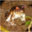

In [4]:
x_train[0]

In [5]:
y_train[0]

array([6], dtype=uint8)

The target labels are encoded in numerical format.  We can create a list of category names to convert the number to its original category name.

In [7]:
x_test.shape

(10000, 32, 32, 3)

- There are 10,000 images in the test data.

### **Converting NumPy arrays to images and visualizing some random images**

As we have observed that all the images are stored as NumPy arrays, and values in the array denote the pixel intensities of the image. We can use matplotlib's **imshow** function to visualize the image from NumPy arrays. we are trying to visualize the data by plotting some random images.

In [8]:
num_classes = 10

# creating a list of category names in alphabetical order
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

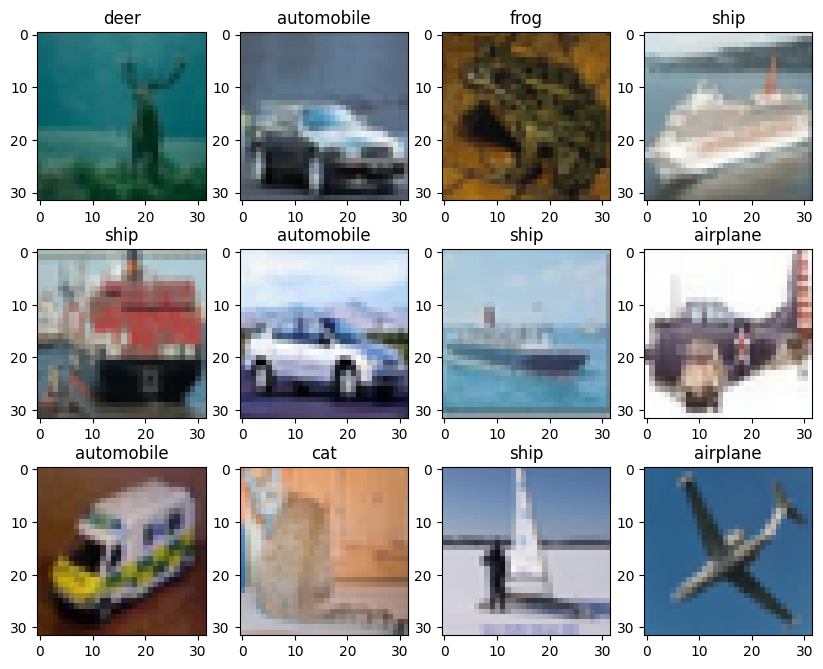

In [9]:
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### **Data Preparation**

We will normalize the images first to speed up training and reduce local optima staleness, optimize weight decay, estimatio, and avoid exploding gradient issues.  The accumulation of large error gradients yield very large updates to neural network model weights during training, known as the problem of exploding gradients. This makes a model unstable and unable to learn from the training data.

The image pixel values range from 0-255. So to standardize images to have their pixel values lie between 0 to 1, we divided images by 255.

In [10]:
# Normalizing the image pixels
x_train_normalized = x_train/255
x_test_normalized = x_test/255

Our output layer should have 10 neurons because this is a 10 classes classification problem. We must also create a one-hot encoded representation for the target classes.

In [11]:
# Create one-hot encoded representation of target labels
# Refer to the function - https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

### **CNN Model**

Set the seed for random number generators in NumPy, Python, and TensorFlow to be always the same, so results can be reproduced always.

In [12]:
#Fix the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

Build our model using Leaky Rectified Linear Unit (LeakyRelu) as the activation function. LeakyReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, that is, it is not learned during training.

Notes to consider:
- In Keras, the input features are 4-dimensional for a Conv2D layer.
- Since we have color images (RGB), our inputs are already 4D.
- If the images were grayscale, the input features should be reshaped to specify that we only have 1 color channel.

##**Initial Model**

In [13]:
# Intializing the sequential model
model_1 = Sequential()

# Add first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_1.add(Dense(100, activation='relu'))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_1.add(Dense(10, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# printing the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

Our CNN model will train and learn 81,814 parameters (weights and biases).

Let's now compile and train the model using the train data. We use the loss function "categorical_crossentropy" because we are performing a multi-class classification. We minimize the loss function output at every iteration using an optimizer

In [15]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=opt, # here we are starting with 0.005 learning rate, by default it is 0.001
    metrics=['accuracy']
)

In [16]:
history_1 = model_1.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1
)

Epoch 1/10
1407/1407 [==============================] - 131s 92ms/step - loss: 1.5348 - accuracy: 0.4405 - val_loss: 1.2385 - val_accuracy: 0.5484
Epoch 2/10
1407/1407 [==============================] - 152s 108ms/step - loss: 1.1530 - accuracy: 0.5912 - val_loss: 1.0304 - val_accuracy: 0.6446
Epoch 3/10
1407/1407 [==============================] - 139s 99ms/step - loss: 1.0031 - accuracy: 0.6458 - val_loss: 0.9869 - val_accuracy: 0.6618
Epoch 4/10
1407/1407 [==============================] - 152s 108ms/step - loss: 0.9058 - accuracy: 0.6834 - val_loss: 0.9185 - val_accuracy: 0.6832
Epoch 5/10
1407/1407 [==============================] - 134s 95ms/step - loss: 0.8368 - accuracy: 0.7065 - val_loss: 0.9141 - val_accuracy: 0.6822
Epoch 6/10
1407/1407 [==============================] - 145s 103ms/step - loss: 0.7800 - accuracy: 0.7270 - val_loss: 0.8819 - val_accuracy: 0.6974
Epoch 7/10
1407/1407 [==============================] - 112s 80ms/step - loss: 0.7269 - accuracy: 0.7441 - val_loss

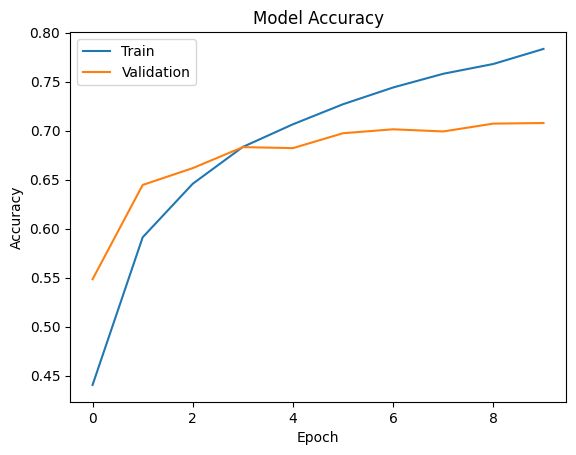

In [17]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
model_1.evaluate(x_test_normalized, y_test_encoded)

313/313 [==============================] - 7s 23ms/step - loss: 0.9119 - accuracy: 0.7051


[0.9118941426277161, 0.7050999999046326]

- Training accuracy: 78.7% and Test Accuracy: 69%.


##**Second Model: Improving Results**

- Implement a more complex model with more CNN layers.
- Use dropout in the FC layers at the end to prevent overfitting.

To proceed, we clear the previous model's history from the session. In Keras, we must use backend.clear_session().

Then, reseed.

Implement the new model using more convolution layers, max-pooling layers, and dropout layers to reduce overfitting.

In [19]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [20]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [21]:
# Intializing a sequential model
model_2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)))
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(64, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model_2.add(Dense(10, activation='softmax'))

# Using Adam Optimizer
opt = Adam()

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
#printing the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

In [23]:
# Compiling the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [24]:
# Fitting the model
history_2 = model_2.fit(
            x_train_normalized, y_train_encoded,
            epochs=10,
            validation_split=0.1
)

Epoch 1/10
1407/1407 [==============================] - 504s 356ms/step - loss: 1.6872 - accuracy: 0.3774 - val_loss: 1.3362 - val_accuracy: 0.5112
Epoch 2/10
1407/1407 [==============================] - 418s 297ms/step - loss: 1.2568 - accuracy: 0.5483 - val_loss: 1.0861 - val_accuracy: 0.6084
Epoch 3/10
1407/1407 [==============================] - 414s 294ms/step - loss: 1.0667 - accuracy: 0.6186 - val_loss: 0.9324 - val_accuracy: 0.6800
Epoch 4/10
1407/1407 [==============================] - 377s 268ms/step - loss: 0.9558 - accuracy: 0.6584 - val_loss: 0.9446 - val_accuracy: 0.6652
Epoch 5/10
1407/1407 [==============================] - 369s 262ms/step - loss: 0.8746 - accuracy: 0.6937 - val_loss: 0.8461 - val_accuracy: 0.7074
Epoch 6/10
1407/1407 [==============================] - 364s 259ms/step - loss: 0.8192 - accuracy: 0.7130 - val_loss: 0.8538 - val_accuracy: 0.7034
Epoch 7/10
1407/1407 [==============================] - 367s 261ms/step - loss: 0.7610 - accuracy: 0.7305 - val_

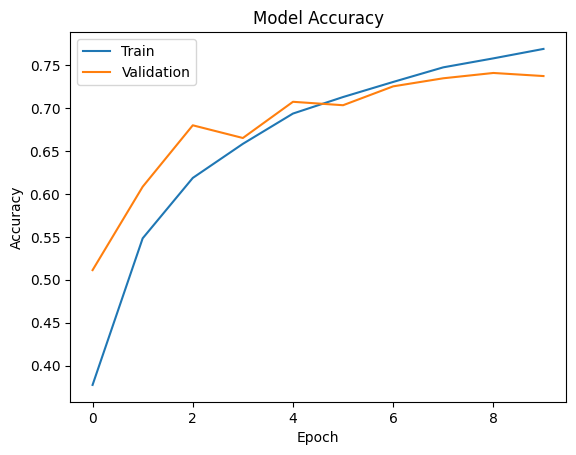

In [25]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
model_2.evaluate(x_test_normalized, y_test_encoded)

313/313 [==============================] - 22s 70ms/step - loss: 0.8270 - accuracy: 0.7221


[0.827012300491333, 0.722100019454956]

**Observations of Second Improved Model:**

- Training accuracy= 78% and Test Accuracy= 71%.
- The improved model with dropout layers has reduced overfitting compared to the first model.
- The validation and test accuracy have increased slightly compared to the first model.
- Using more convolutions helped us a slight performance improvement.

Hyperparameter can be implemented to further improve performance.

##**Predictions**

In [27]:
#Making predictions on the test data
y_pred_test = model_2.predict(x_test_normalized)

#Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

313/313 [==============================] - 22s 69ms/step


              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1000
           1       0.85      0.89      0.87      1000
           2       0.72      0.51      0.60      1000
           3       0.49      0.55      0.52      1000
           4       0.74      0.60      0.66      1000
           5       0.52      0.76      0.62      1000
           6       0.81      0.76      0.78      1000
           7       0.77      0.78      0.77      1000
           8       0.88      0.78      0.83      1000
           9       0.79      0.86      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



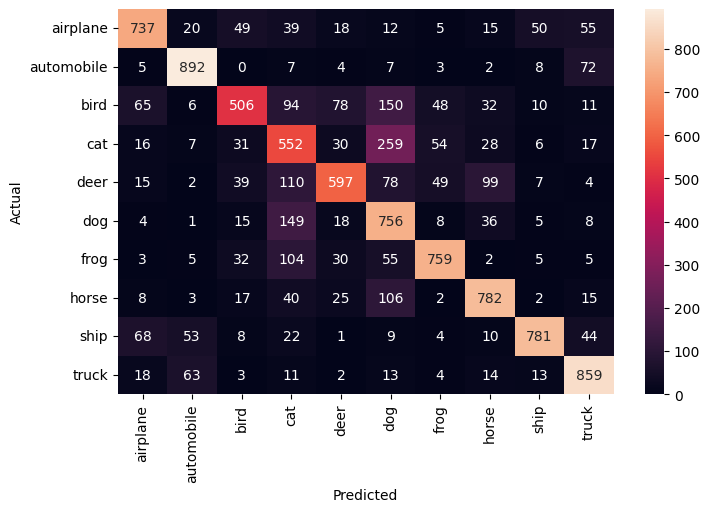

In [28]:
#importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Printing the classification report
print(classification_report(y_test, y_pred_test_classes))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:**

- The model is giving about 71% accuracy on the test data, similar to the accuracy of the validation.
- The model confuses cats and dogs. This indicates that the model might be focused on features related to shapes and sizes but not deep features of objects which can help to distinguish between objects like cats and dogs.
- Precision has a high range with the 'cat' class having the least precision.
- The highest precision is for 'automobile' which indicates that the model can distinguish automobiles from other objects.

### **Visualizing predicted images**

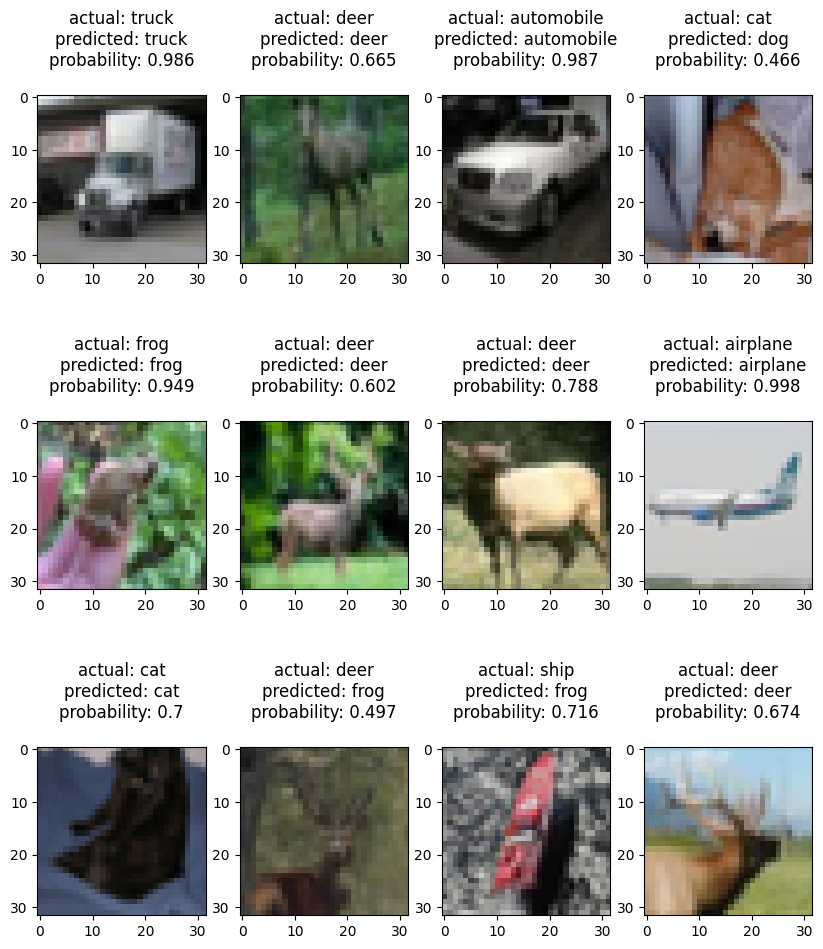

In [29]:
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()